###Project Summary
<img src ='https://images.unsplash.com/photo-1548859047-1d15def63a14?ixlib=rb-1.2.1&ixid=MXwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHw%3D&auto=format&fit=crop&w=2700&q=80' width="800" height = "200">
######Dr. Wei Zhai (Assistant Professor at Hong Kong Baptist University) and Ivy(Ruxin) Tong | Oct 15th, 2021 | Image courtesy of Ivan Olenkevich

####**Objective** : Evaluation and Prediction of American’s Mobility under Extreme Weather Events using Artificial Intelligence (Microsoft AI for Earth Grant)


####**Datasets** :  Weather_CBG_2019 | Social Distancing Metrics v2.1 | Top 100 CBG City
######***About the data***
- ***Dataset - Weather_CBG_2019 records daily weather parameters by census block group in the United States. There're 7 variables*** 

| Variable   | Description  | Unit | 
|-----------------  |---------------|------|
| geoid    | census block group ID |  | 
| precip  | daily precipitation | mm|
| rmax | maximum daily relative humidity | % |
| rmin | mminimum daily relative humidity | % |
| srad | surface downwelling solar radiation | W/m^2 |
| tmax | maximum daily temperature | degress F |
| tmin | minimum daily temperature | degress F |
| wind_speed | wind speed | mph|


- ***Dataset - Social Distancing Metrics v2.1 is a product of Safegraph which aggregately summarizes daily views of USA foot-traffic between census block groups. There're 23 variables. For this analysis, I mainly use ***

     *description based on Safegraph documentation*
  
| Variable   | Description  | Unit | 
|-----------------  |---------------|------|
| origin_census_block_group    | 12-digit FIPS code for the Census Block Group |  | 
| distance_traveled_from_home  | Median distance traveled from the geohash-7 of the home by the devices measured within the time period. All distance with 0 has been excluded. | meter |
| date_range_start  | Start time for measurement | YYYY-MM-DDTHH:mm:SS±hh:mm |
| date_range_end  | End time for measurement  | YYYY-MM-DDTHH:mm:SS±hh:mm|
| device_count | Total number of devices seen during the date range | count  |
| median_home_dwell_time  | Median dwell time at home during the time period |  min |  
| completely_home_device_count  | Number of device devices do not leave the house during the time period | count  |  

- ***Dataset - Top 100 CBG City. There're 4 variables*** 

| Variable   | Description  |
|-----------------  |---------------|
| geoid10    | census block group ID | 
| name  | name of city |
| class | municipality |
| st | state abbreviation |






- ***Additional variables created for the analysis ***


| Variable   | Description  | Unit | 
|-----------------  |---------------|------|
| month   | month of each year | 1-12 | 
| day  | day of each year | 1-31 |
| weekday  | day of each week | 0-6 (0 for Mon) |
| ratio of not leaving | completely_home_device_count / device_count | ratio between 0 and 1 |

  
  
######***Acknowledgements*** : Social Distancing Metrics v2.1 is downloaded "from [SafeGraph](https://www.safegraph.com/), a data company that aggregates anonymized location data from numerous applications in order to provide insights about physical places, via the [Placekey](https://www.placekey.io/) Community. To enhance privacy, SafeGraph excludes census block group information if fewer than five devices visited an establishment in a month from a given census block group.”




####**Conclusion**:




####**Model and Result**:


####**Notebook** : There are two notebooks for this project:

Notebook1 details the data analysis for 2019 weather dataset, Jan social distancing dataset, and initial Jan modeling (mainly in Python) [Current]   

Notebook2 idetails 2019 whole year modeling (mainly in Spark)

#### Analysis
###### Step 0 : Install and Import libraries

In [0]:
%run ./Packages_setup

###### Step 1 : Data Preparation and Analysis for weather_cbg_2019
  - Secure access to  AWS s3 bucket and read the dataset

In [0]:
# # Mount a bucket using AWS keys (write and read access to all the objects in the S3 buckets). Alternatively, use AWS instance profile)
awsAccessKey = ""
secretKey = "".replace("/", "%2F")
awsBucketName = "weathercbg2019"
mountPoint = f"/mnt/weathercbg"

mountTarget = "s3a://{}:{}@{}".format(awsAccessKey, secretKey, awsBucketName)
dbutils.fs.mount(mountTarget, mountPoint)

In [0]:
dbutils.fs.ls("/mnt/weathercbg")

In [0]:
dbutils.fs.head("dbfs:/mnt/weathercbg/weather_cbg_2019.csv",1000)

In [0]:
# # #read weathercbgDF
weathercbgDF = (spark.read
  .option("delimiter", ",")
  .option("header", True)
  .option("inferSchema", True)
  .csv("/mnt/weathercbg/weather_cbg_2019.csv")
 )

- Transform and Explore the weather dataset

In [0]:
# #  Add three date-related variables
weathercbgDF = weathercbgDF.withColumn("month", F.month('date'))
weathercbgDF = weathercbgDF.withColumn("day", F.dayofmonth('date'))
weathercbgDF = weathercbgDF.withColumn("year", F.year('date'))
weathercbgDF.show(5)
# save to local folder so that we can access directly through databricks
weathercbgDF.write.format('com.databricks.spark.csv').save("/FileStore/weathercbgDF.csv",header = 'true',inferSchema = "true")

In [0]:
#   unmount s3
try:
  dbutils.fs.unmount(mountPoint)
except:
  print("{} already unmounted".format(mountPoint))

In [0]:
#decide to add a new variable after unmounting to s3
weathercbgDF = spark.read.format("csv").option("header", "true").option("inferSchema","true").load("/FileStore/weathercbgDF.csv")
# weathercbgDF =weathercbgDF.withColumn('day_of_week',dayofweek(weathercbgDF.date))

def spark_df_shape(self):
    return (self.count(),len(self.columns)) 
pyspark.sql.dataframe.DataFrame.shape = spark_df_shape


print("weather cbg 2019 dataset")
weathercbgDF.printSchema()
print("shape:")
print(weathercbgDF.shape())

weather cbg 2019 dataset
root
-- geoid: long (nullable = true)
-- date: string (nullable = true)
-- precip: double (nullable = true)
-- rmax: double (nullable = true)
-- rmin: double (nullable = true)
-- srad: double (nullable = true)
-- tmin: double (nullable = true)
-- tmax: double (nullable = true)
-- wind_speed: double (nullable = true)
-- month: integer (nullable = true)
-- day: integer (nullable = true)
-- year: integer (nullable = true)

shape:
(78654945, 12)

In [0]:
from pyspark.sql.functions import min, max

display(
  weathercbgDF.select(min("date"), max("date"))
)

min(date),max(date)
2019-01-01,2019-12-31


- Create summary table group by month and geoid & Basic visualization

In [0]:
#   create monthly summary table group by geoid, for visualization and faster operation
weather_cbg_month = (weathercbgDF.groupBy("geoid","month")
                            .agg(
                              mean("precip").alias("mean_precip"),
                              mean("rmax").alias("mean_rmax"),
                              mean("rmin").alias("mean_rmin"),
                              mean("srad").alias("mean_srad"),
                              mean("tmin").alias("mean_tmin"),
                              mean("tmax").alias("mean_tmax"),
                              mean("wind_speed").alias("mean_wind_speed"))
                             .sort(["geoid","month"]))

weather_cbg_month.show(5)

weather_cbg_month.write.format('com.databricks.spark.csv').save("/FileStore/weather_cbg_month.csv",header = 'true',inferSchema = 'true')

In [0]:
## Generate a sample for exploratory data analysis
weather_cbg_month = spark.read.format("csv").option("header", "true",).option("inferSchema", "true").load("/FileStore/weather_cbg_month.csv") 
weather_cbg_month.printSchema()

weather_cbg_2019_month_sample =weather_cbg_month.sample(0.01).toPandas()
weather_cbg_2019_month_sample.head()

,geoid,month,mean_precip,mean_rmax,mean_rmin,mean_srad,mean_tmin,mean_tmax,mean_wind_speed
0,360550117054,2,2.086,84.064,48.271,111.157,20.011,36.018,11.976
1,360550121004,1,2.106,90.106,57.297,80.471,15.710,29.553,12.289
2,360550123012,2,2.150,84.343,49.146,110.461,20.191,36.018,12.279
3,360550123012,3,1.287,85.400,45.123,162.816,23.386,41.903,11.055
4,360550123041,4,2.353,85.810,46.040,216.390,36.272,56.144,10.484


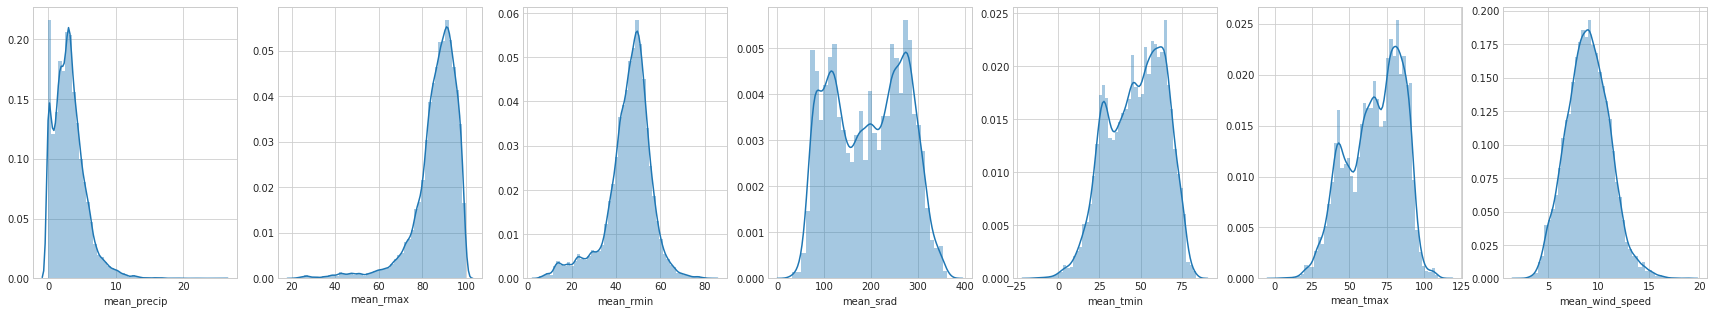

In [0]:
# Understand distribution of Variables
variables = weather_cbg_2019_month_sample.drop(["geoid","month"], axis = 1)
fig,ax = plt.subplots(1,7, figsize= (30,5))

for i, variable in enumerate(variables):
  sns.distplot(variables[variable], ax=ax[i])

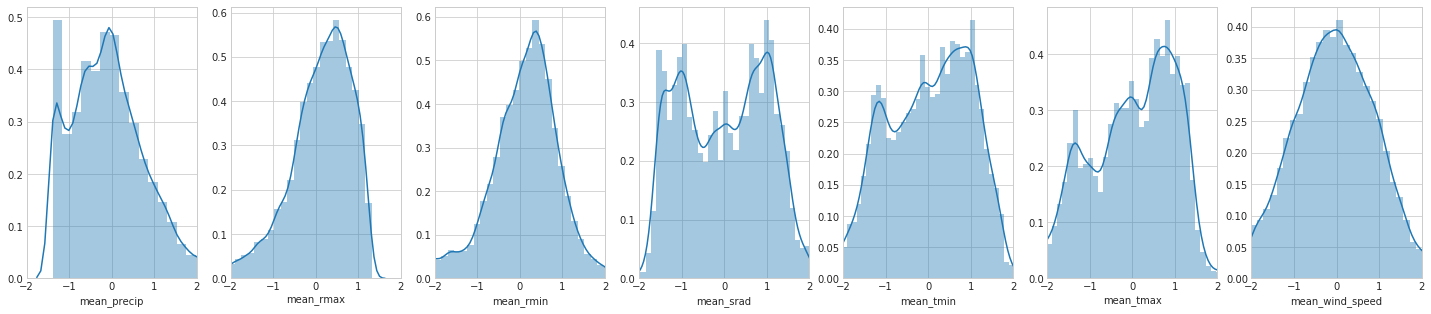

In [0]:
# these distributions are not on the same scale, standardize them
fix, ax = plt.subplots(1,7,figsize = (25,5))

for i, variable in enumerate(variables):
  original_variables = variables[variable]
  variable_scaled = (original_variables - original_variables.mean())/original_variables.std()
  sns.distplot(variable_scaled, ax=ax[i])
  ax[i].set_xlim(-2,2)

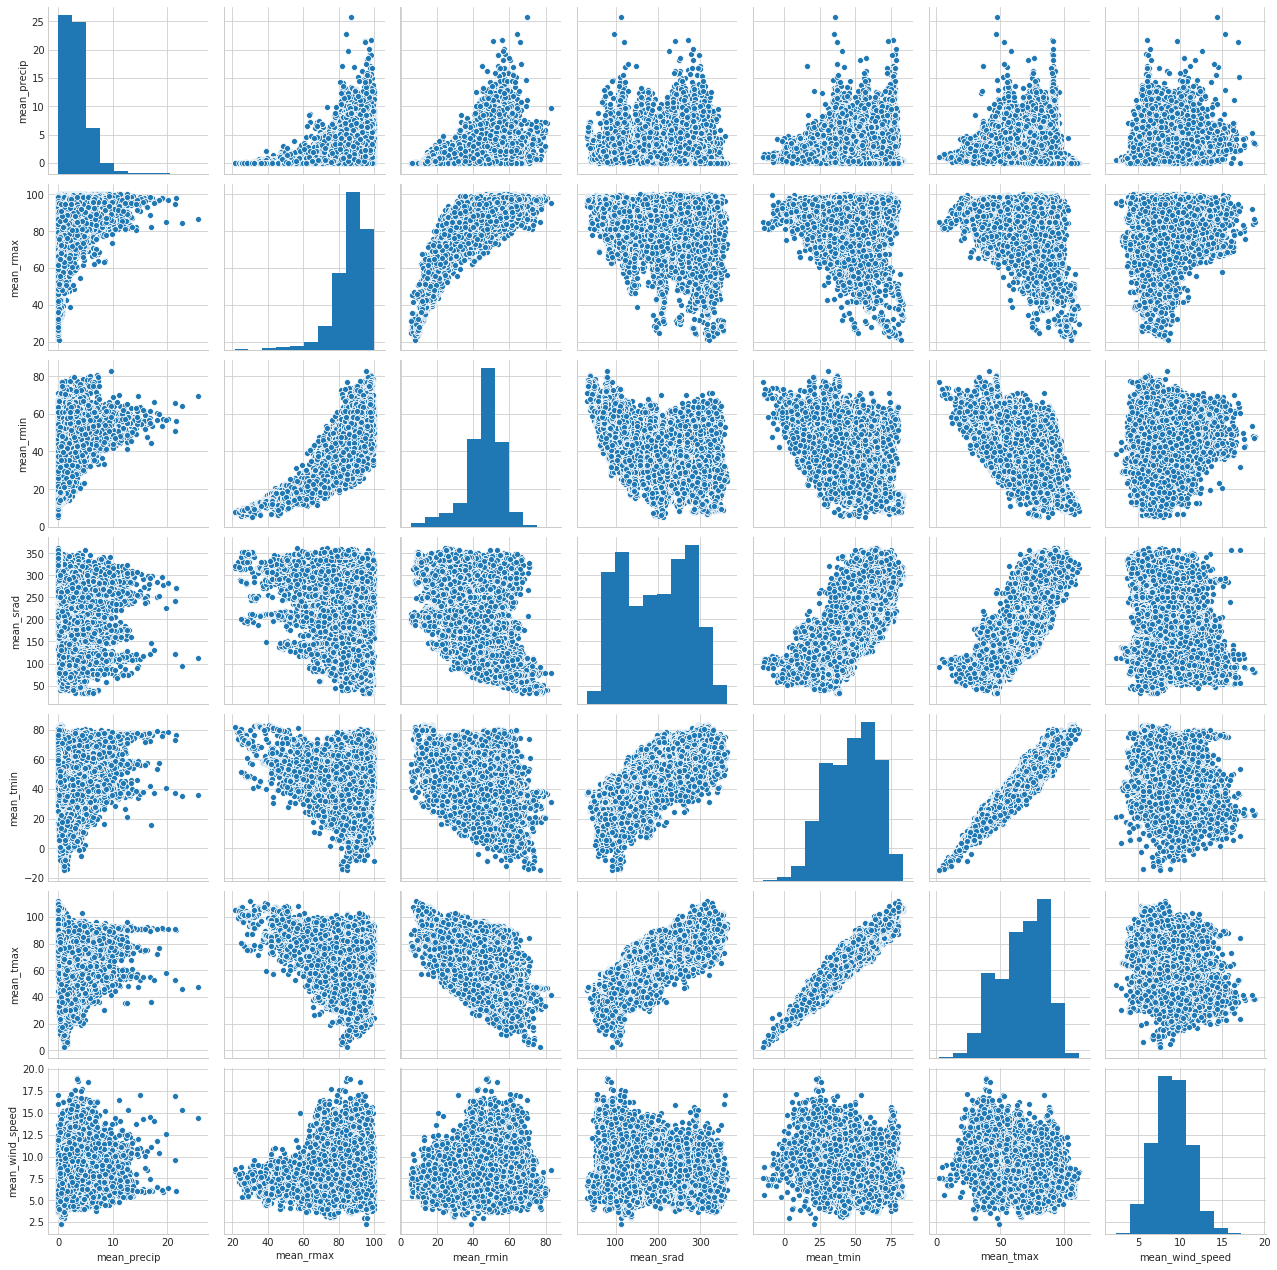

In [0]:
#correlation
g = sns.pairplot(variables)
g.fig.set_size_inches(15,10)

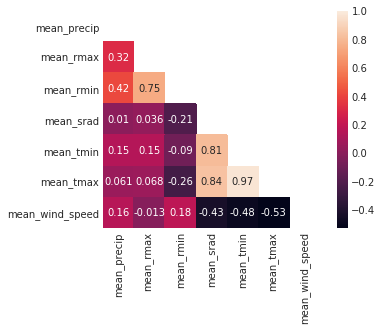

In [0]:
corr = variables.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask,0)] = True
sns.heatmap(corr, mask = mask,square = True, annot = True)

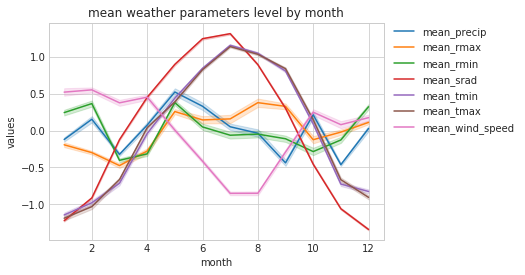

In [0]:
# # scaled data by month. This is generally the US case, it varies by the region
for i, variable in enumerate(variables):
  original_variables = variables[variable]
  variable_scaled = (original_variables - original_variables.mean())/original_variables.std()
  sns.lineplot(x = "month", y=variable_scaled, data = weather_cbg_2019_month_sample,legend='brief', label=variable)

plt.ylabel("values")
plt.legend(bbox_to_anchor=(1.02, 1),borderaxespad=0.)
plt.title("mean weather parameters level by month")


- Prepare Jan file for initial modeling

In [0]:
# Prepare Jan file for initial modeling
weatherDF_Jan = weathercbgDF.where(col("month") == 1).toPandas()
weatherDF_Jan.head(10)

Out[5]:

,geoid,date,precip,rmax,rmin,srad,tmin,tmax,wind_speed,month,day,year
0,10730059033,2019-01-01,0.000,97.200,65.200,111.800,48.470,61.970,2.461,1,1,2019
1,10730059033,2019-01-02,20.900,86.300,81.600,30.600,48.470,52.790,3.355,1,2,2019
2,10730059033,2019-01-03,24.900,79.400,63.100,59.200,50.630,59.450,5.816,1,3,2019
3,10730059033,2019-01-04,0.900,100.000,55.700,99.100,40.550,62.150,14.316,1,4,2019
4,10730059033,2019-01-05,0.000,87.600,39.200,126.800,36.950,60.170,7.382,1,5,2019
5,10730059033,2019-01-06,0.000,95.800,33.200,119.400,36.770,66.830,2.908,1,6,2019
6,10730059033,2019-01-07,0.400,83.800,38.300,126.500,44.150,67.370,7.158,1,7,2019
7,10730059033,2019-01-08,0.000,100.000,43.900,116.400,42.710,68.990,8.948,1,8,2019
8,10730059033,2019-01-09,0.000,68.600,34.000,135.000,31.730,51.530,10.961,1,9,2019
9,10730059033,2019-01-10,0.000,60.100,31.100,133.500,27.410,45.590,8.053,1,10,2019


In [0]:
print(weatherDF_Jan.shape)
print(weatherDF_Jan.geoid.nunique())
weatherDF_Jan.info()

Out[14]: (6680283, 12)

In [0]:
weatherDF_Jan[weatherDF_Jan.geoid == 40130101022].head()

,geoid,date,precip,rmax,rmin,srad,tmin,tmax,wind_speed,month,day,year
5906078,40130101022,2019-01-01,0.000,98.100,45.900,131.500,24.530,43.430,4.474,1,1,2019
5906079,40130101022,2019-01-02,0.000,69.500,25.000,135.900,23.810,46.850,3.803,1,2,2019
5906080,40130101022,2019-01-03,0.000,53.200,16.900,140.200,30.650,54.950,3.132,1,3,2019
5906081,40130101022,2019-01-04,0.000,46.000,12.700,140.900,37.310,63.770,3.803,1,4,2019
5906082,40130101022,2019-01-05,18.900,58.700,19.700,98.500,39.470,64.310,7.158,1,5,2019


###### Step 2 : Data Preparation and Analysis for Social Distancing Metrics v2.1

- Get data from Safegraph
    - Download this dataset from safegraph through cluster terminal to filepath 'cd databricks/driver/mnt/' -> Move them to '/dbfs/mnt#'

In [0]:
# use this command to move files so that I can directly access from databricks data UI
dbutils.fs.mv(r"file:/mnt/", r"dbfs:/social_distance_data/", True)

In [0]:
%fs ls /social_distance_data/social_distance/2019/

path,name,size
dbfs:/social_distance_data/social_distance/2019/01/,01/,0
dbfs:/social_distance_data/social_distance/2019/02/,02/,0
dbfs:/social_distance_data/social_distance/2019/03/,03/,0
dbfs:/social_distance_data/social_distance/2019/04/,04/,0
dbfs:/social_distance_data/social_distance/2019/05/,05/,0
dbfs:/social_distance_data/social_distance/2019/06/,06/,0
dbfs:/social_distance_data/social_distance/2019/07/,07/,0
dbfs:/social_distance_data/social_distance/2019/08/,08/,0
dbfs:/social_distance_data/social_distance/2019/09/,09/,0
dbfs:/social_distance_data/social_distance/2019/10/,10/,0


In [0]:
%fs ls /social_distance_data/social_distance/2019/01

path,name,size
dbfs:/social_distance_data/social_distance/2019/01/01/,01/,0
dbfs:/social_distance_data/social_distance/2019/01/02/,02/,0
dbfs:/social_distance_data/social_distance/2019/01/03/,03/,0
dbfs:/social_distance_data/social_distance/2019/01/04/,04/,0
dbfs:/social_distance_data/social_distance/2019/01/05/,05/,0
dbfs:/social_distance_data/social_distance/2019/01/06/,06/,0
dbfs:/social_distance_data/social_distance/2019/01/07/,07/,0
dbfs:/social_distance_data/social_distance/2019/01/08/,08/,0
dbfs:/social_distance_data/social_distance/2019/01/09/,09/,0
dbfs:/social_distance_data/social_distance/2019/01/10/,10/,0


In [0]:
%fs ls /social_distance_data/social_distance/2019/01/01

path,name,size
dbfs:/social_distance_data/social_distance/2019/01/01/2019-01-01-social-distancing.csv.gz,2019-01-01-social-distancing.csv.gz,90505721


- Preparing SafeGraph social-distancing data
    - read one gzip file first to understand panda dataframe
    - read January data and prepare it for initial modeling, reason being that i wanna test the model out before scaling up the whole dataset
    - read all 2019 social-distancing dataset (approx 800M rows)

In [0]:
# use panda to read one file 
sd20190101 = pd.read_csv("/dbfs/social_distance_data/social_distance/2019/01/01/2019-01-01-social-distancing.csv.gz",compression = "gzip")
sd20190101.head() 

,origin_census_block_group,date_range_start,date_range_end,device_count,distance_traveled_from_home,bucketed_distance_traveled,median_dwell_at_bucketed_distance_traveled,completely_home_device_count,median_home_dwell_time,bucketed_home_dwell_time,at_home_by_each_hour,part_time_work_behavior_devices,full_time_work_behavior_devices,destination_cbgs,delivery_behavior_devices,median_non_home_dwell_time,candidate_device_count,bucketed_away_from_home_time,median_percentage_time_home,bucketed_percentage_time_home,mean_home_dwell_time,mean_non_home_dwell_time,mean_distance_traveled_from_home
0,10330210004,2019-01-01T00:00:00-06:00,2019-01-02T00:00:00-06:00,78,687,"{""16001-50000"":14,""0"":28,"">50000"":8,""2001-8000...","{""16001-50000"":38,"">50000"":207,""<1000"":52,""200...",28,714,"{""721-1080"":14,""361-720"":14,""61-360"":5,""<60"":1...","[42,44,45,46,46,45,42,44,44,41,48,39,37,33,30,...",7,1,"{""281419502003"":1,""010330210003"":5,""2401503010...",1,52,179,"{""21-45"":3,""481-540"":1,""541-600"":1,""46-60"":4,""...",92,"{""0-25"":17,""76-100"":51,""51-75"":5,""26-50"":1}",721,209,134263
1,10730049022,2019-01-01T00:00:00-06:00,2019-01-02T00:00:00-06:00,259,5381,"{""16001-50000"":12,""0"":94,"">50000"":58,""2001-800...","{""16001-50000"":165,"">50000"":177,""<1000"":129,""2...",93,58,"{""721-1080"":22,""361-720"":23,""61-360"":57,""<60"":...","[48,53,56,58,57,62,59,63,63,62,61,62,56,57,54,...",13,2,"{""121030273154"":1,""132150004003"":1,""0107301310...",1,44,1312,"{""21-45"":16,""481-540"":5,""541-600"":7,""46-60"":8,...",53,"{""0-25"":112,""76-100"":117,""51-75"":12,""26-50"":14}",292,221,76229
2,11210118001,2019-01-01T00:00:00-06:00,2019-01-02T00:00:00-06:00,91,1591,"{""16001-50000"":5,""0"":46,"">50000"":10,""2001-8000...","{""16001-50000"":84,"">50000"":247,""<1000"":181,""20...",45,487,"{""721-1080"":13,""361-720"":17,""61-360"":13,""<60"":...","[40,40,42,41,36,41,40,41,41,37,39,39,34,36,34,...",3,1,"{""011150405022"":2,""011210118002"":7,""0103796110...",1,0,299,"{""21-45"":3,""541-600"":1,""46-60"":1,""721-840"":1,""...",100,"{""0-25"":25,""76-100"":53,""51-75"":6,""26-50"":4}",588,181,15741
3,11250106021,2019-01-01T00:00:00-06:00,2019-01-02T00:00:00-06:00,392,4623,"{""16001-50000"":55,""0"":172,"">50000"":32,""2001-80...","{""16001-50000"":61,"">50000"":86,""<1000"":62,""2001...",171,860,"{""721-1080"":60,""361-720"":50,""61-360"":46,""<60"":...","[212,225,231,240,238,234,239,235,229,229,227,2...",26,8,"{""010730142031"":4,""010730141021"":2,""1313505054...",1,20,1059,"{""21-45"":26,""481-540"":2,""541-600"":7,""46-60"":14...",97,"{""0-25"":66,""76-100"":274,""51-75"":24,""26-50"":22}",770,172,12937
4,21880002003,2019-01-01T00:00:00-09:00,2019-01-02T00:00:00-09:00,10,0,"{""1-1000"":1,"">50000"":2,""0"":1}","{"">50000"":33,""<1000"":10}",3,1197,"{"">1080"":5,""<60"":1,""61-360"":1}","[1,3,4,3,7,4,5,5,6,4,6,6,4,7,7,5,5,3,8,1,6,8,5,5]",1,1,"{""021880002003"":6,""550790217005"":1,""0218800020...",1,10,36,"{""<20"":5,""601-660"":1,""361-420"":1,""841-960"":1}",99,"{""0-25"":4,""76-100"":5,""26-50"":1}",857,241,0


In [0]:
print(sd20190101.shape)
sd20190101.info()

Out[22]: (219490, 23)

In [0]:
#lets' take a look at the destination column
!pip install -q --upgrade git+https://github.com/SafeGraphInc/safegraph_py
from safegraph_py_functions.safegraph_py_functions import *
destination = sd20190101[['origin_census_block_group','destination_cbgs']]
unpack_json_and_merge_fast(destination, json_column='destination_cbgs', key_col_name='destination_cbgs_exploded', value_col_name='destination_cbgs_count', chunk_n= 1000).drop('destination_cbgs',axis = 1).head()

,origin_census_block_group,destination_cbgs_exploded,destination_cbgs_count
0,10330210004,281419502003,1
1,10330210004,010330210003,5
2,10330210004,240150301002,1
3,10330210004,471150502012,1
4,10330210004,010770102002,2


In [0]:
#bucket distance travel
bucket_distance = sd20190101[['origin_census_block_group','bucketed_distance_traveled']]
unpack_json_and_merge_fast(bucket_distance, json_column='bucketed_distance_traveled', key_col_name='bucketed_distance_traveled_exploded', value_col_name='bucketed_distance_traveled_count', chunk_n= 1000).drop('bucketed_distance_traveled',axis = 1).head()

,origin_census_block_group,bucketed_distance_traveled_exploded,bucketed_distance_traveled_count
0,10330210004,16001-50000,14
1,10330210004,0,28
2,10330210004,>50000,8
3,10330210004,2001-8000,5
4,10330210004,1-1000,11


- Initial Modeling for Jan data only - Part 1
   - Prepare Jan social distancing dataset

In [0]:
# Prepare January file for initial modeling
Jan_files = glob.glob("/dbfs/social_distance_data/social_distance/2019/01/*/*")

li= []
for file in Jan_files:
    df = pd.read_csv(file, compression='gzip', usecols=['origin_census_block_group','date_range_start','date_range_end','distance_traveled_from_home','mean_home_dwell_time','completely_home_device_count','device_count'])
    li.append(df)

sd_data_jan = pd.concat(li, axis=0, ignore_index=True)
del li
sd_data_jan.head(10)

,origin_census_block_group,date_range_start,date_range_end,device_count,distance_traveled_from_home,completely_home_device_count,mean_home_dwell_time
0,10330210004,2019-01-01T00:00:00-06:00,2019-01-02T00:00:00-06:00,78,687,28,721
1,10730049022,2019-01-01T00:00:00-06:00,2019-01-02T00:00:00-06:00,259,5381,93,292
2,11210118001,2019-01-01T00:00:00-06:00,2019-01-02T00:00:00-06:00,91,1591,45,588
3,11250106021,2019-01-01T00:00:00-06:00,2019-01-02T00:00:00-06:00,392,4623,171,770
4,21880002003,2019-01-01T00:00:00-09:00,2019-01-02T00:00:00-09:00,10,0,3,857
5,40019450014,2019-01-01T00:00:00-07:00,2019-01-02T00:00:00-07:00,97,615,33,204
6,40130101023,2019-01-01T00:00:00-07:00,2019-01-02T00:00:00-07:00,135,3635,47,687
7,40132175012,2019-01-01T00:00:00-07:00,2019-01-02T00:00:00-07:00,79,1205,55,799
8,40136145004,2019-01-01T00:00:00-07:00,2019-01-02T00:00:00-07:00,89,1435,28,802
9,40136170001,2019-01-01T00:00:00-07:00,2019-01-02T00:00:00-07:00,59,2557,23,821


In [0]:
sd_data_jan['date_range_start'] = pd.to_datetime(sd_data_jan['date_range_start'],utc= True)
sd_data_jan['date_range_end'] = pd.to_datetime(sd_data_jan['date_range_end'],utc= True)
sd_data_jan['month'] = sd_data_jan['date_range_start'].dt.month
sd_data_jan['day'] = sd_data_jan['date_range_start'].dt.day
sd_data_jan['dayofweek'] = sd_data_jan['date_range_start'].dt.dayofweek
sd_data_jan['date_time'] = sd_data_jan['date_range_end']-sd_data_jan['date_range_start']
# sd_data_jan['date'] = [d.date() for d in sd_data_jan['date_range_start']]
sd_data_jan['ratio_not_leaving'] = round(sd_data_jan['completely_home_device_count']/sd_data_jan['device_count'],4)
sd_data_jan = sd_data_jan.drop(['date_range_start','date_range_end'],1)

# sd_data_jan.to_csv("/dbfs/social_distance_data/jan.csv",index= False)  # save it for next time use

In [0]:
sd_data_jan = pd.read_csv("/dbfs/social_distance_data/jan.csv")
sd_data_jan.head()

Out[6]:

,origin_census_block_group,device_count,distance_traveled_from_home,completely_home_device_count,mean_home_dwell_time,month,day,dayofweek,date_time,ratio_not_leaving
0,10330210004,78,687,28,721,1,1,1,1 days 00:00:00.000000000,0.359
1,10730049022,259,5381,93,292,1,1,1,1 days 00:00:00.000000000,0.359
2,11210118001,91,1591,45,588,1,1,1,1 days 00:00:00.000000000,0.494
3,11250106021,392,4623,171,770,1,1,1,1 days 00:00:00.000000000,0.436
4,21880002003,10,0,3,857,1,1,1,1 days 00:00:00.000000000,0.300


In [0]:
sd_data_jan.shape

Out[47]: (6805915, 10)

In [0]:
sd_data_jan[sd_data_jan.date_time > '1 days 00:00:00']

,origin_census_block_group,device_count,distance_traveled_from_home,completely_home_device_count,mean_home_dwell_time,month,day,dayofweek,date_time,ratio_not_leaving
4297985,21989401001,20,0,15,954,1,20,6,1 days 01:00:00,0.750
4315583,21989401002,61,155,33,817,1,20,6,1 days 01:00:00,0.541
4328180,21989401003,6,272,1,654,1,20,6,1 days 01:00:00,0.167


In [0]:
sd_data_jan.origin_census_block_group.nunique()  # 219759
sd_data_jan.origin_census_block_group[~sd_data_jan.origin_census_block_group.isin(weatherDF_Jan.geoid)].nunique() # 4869

Out[58]: 4869

- Initial Modeling for Jan data only - Part 2
   - Join Jan weather and Jan social distancing dataset together

In [0]:
# sd_data_jan = pd.read_csv("./social_distance_data/jan.csv")
merge_Jan = pd.merge(sd_data_jan.drop('date_time',1), weatherDF_Jan, how='inner', left_on=['origin_census_block_group','day','month'], right_on = ['geoid','day','month'])
merge_Jan.head()

Out[7]:

,origin_census_block_group,device_count,distance_traveled_from_home,completely_home_device_count,mean_home_dwell_time,month,day,dayofweek,ratio_not_leaving,geoid,date,precip,rmax,rmin,srad,tmin,tmax,wind_speed,year
0,10330210004,78,687,28,721,1,1,1,0.359,10330210004,2019-01-01,0.400,99.900,67.600,110.300,43.430,56.390,6.263,2019
1,10730049022,259,5381,93,292,1,1,1,0.359,10730049022,2019-01-01,0.000,94.700,66.500,111.900,50.270,62.510,2.908,2019
2,11210118001,91,1591,45,588,1,1,1,0.494,11210118001,2019-01-01,0.000,98.200,64.300,99.600,49.370,63.770,2.908,2019
3,11250106021,392,4623,171,770,1,1,1,0.436,11250106021,2019-01-01,0.000,94.800,65.800,117.700,50.090,63.050,4.026,2019
4,40019450014,97,615,33,204,1,1,1,0.340,40019450014,2019-01-01,0.600,100.000,69.300,87.000,-3.730,25.790,3.803,2019


In [0]:
merge_Jan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6656671 entries, 0 to 6656670
Data columns (total 19 columns):
 # Column Dtype 
--- ------ ----- 
 0 origin_census_block_group int64 
 1 device_count int64 
 2 distance_traveled_from_home int64 
 3 completely_home_device_count int64 
 4 mean_home_dwell_time int64 
 5 month int64 
 6 day int64 
 7 dayofweek int64 
 8 ratio_not_leaving float64
 9 geoid int64 
 10 date object 
 11 precip float64
 12 rmax float64
 13 rmin float64
 14 srad float64
 15 tmin float64
 16 tmax float64
 17 wind_speed float64
 18 year int32 
dtypes: float64(8), int32(1), int64(9), object(1)
memory usage: 990.3+ MB

In [0]:
# !pip install openpyxl
narrow_search_list = pd.read_excel("/dbfs/FileStore/tables/CBG_city_in_top_100_yizi.xlsx", usecols = ['GEOID10','NAME','CLASS','ST'],engine='openpyxl')  
print(narrow_search_list.GEOID10.nunique() == narrow_search_list.shape[0])
narrow_search_list.head()

True
Out[10]:

,GEOID10,NAME,CLASS,ST
0,20200001011,Anchorage,municipality,AK
1,20200001012,Anchorage,municipality,AK
2,20200001013,Anchorage,municipality,AK
3,20200001021,Anchorage,municipality,AK
4,20200001022,Anchorage,municipality,AK


In [0]:
merge_Jan_list = pd.merge(narrow_search_list,merge_Jan.drop('geoid',1), how = 'inner', left_on = ['GEOID10'], right_on = ['origin_census_block_group'])
merge_Jan_list.head()

Out[11]:

,GEOID10,NAME,CLASS,ST,origin_census_block_group,device_count,distance_traveled_from_home,completely_home_device_count,mean_home_dwell_time,month,day,dayofweek,ratio_not_leaving,date,precip,rmax,rmin,srad,tmin,tmax,wind_speed,year
0,40130101022,Scottsdale,city,AZ,40130101022,95,6618,38,786,1,1,1,0.400,2019-01-01,0.000,98.100,45.900,131.500,24.530,43.430,4.474,2019
1,40130101022,Scottsdale,city,AZ,40130101022,102,7194,39,763,1,2,2,0.382,2019-01-02,0.000,69.500,25.000,135.900,23.810,46.850,3.803,2019
2,40130101022,Scottsdale,city,AZ,40130101022,96,8033,31,710,1,3,3,0.323,2019-01-03,0.000,53.200,16.900,140.200,30.650,54.950,3.132,2019
3,40130101022,Scottsdale,city,AZ,40130101022,91,7932,21,739,1,4,4,0.231,2019-01-04,0.000,46.000,12.700,140.900,37.310,63.770,3.803,2019
4,40130101022,Scottsdale,city,AZ,40130101022,98,7286,29,683,1,5,5,0.296,2019-01-05,18.900,58.700,19.700,98.500,39.470,64.310,7.158,2019


In [0]:
merge_Jan_list.shape

Out[12]: (1349693, 22)

In [0]:
merge_Jan_list[merge_Jan_list.GEOID10==40130101022].head()

,GEOID10,NAME,CLASS,ST,origin_census_block_group,device_count,distance_traveled_from_home,completely_home_device_count,mean_home_dwell_time,month,day,dayofweek,ratio_not_leaving,date,precip,rmax,rmin,srad,tmin,tmax,wind_speed,year
0,40130101022,Scottsdale,city,AZ,40130101022,95,6618,38,786,1,1,1,0.400,2019-01-01,0.000,98.100,45.900,131.500,24.530,43.430,4.474,2019
1,40130101022,Scottsdale,city,AZ,40130101022,102,7194,39,763,1,2,2,0.382,2019-01-02,0.000,69.500,25.000,135.900,23.810,46.850,3.803,2019
2,40130101022,Scottsdale,city,AZ,40130101022,96,8033,31,710,1,3,3,0.323,2019-01-03,0.000,53.200,16.900,140.200,30.650,54.950,3.132,2019
3,40130101022,Scottsdale,city,AZ,40130101022,91,7932,21,739,1,4,4,0.231,2019-01-04,0.000,46.000,12.700,140.900,37.310,63.770,3.803,2019
4,40130101022,Scottsdale,city,AZ,40130101022,98,7286,29,683,1,5,5,0.296,2019-01-05,18.900,58.700,19.700,98.500,39.470,64.310,7.158,2019


In [0]:
merge_Jan_list.describe()

,GEOID10,origin_census_block_group,device_count,distance_traveled_from_home,completely_home_device_count,mean_home_dwell_time,month,day,dayofweek,ratio_not_leaving,precip,rmax,rmin,srad,tmin,tmax,wind_speed,year
count,1349693.000,1349693.000,1349693.000,1349693.000,1349693.000,1349693.000,1349693.000,1349693.000,1349693.000,1349693.000,1349693.000,1349693.000,1349693.000,1349693.000,1349693.000,1349693.000,1349693.000,1349693.000
mean,282377492890.544,282377492890.544,100.148,2311.096,39.430,658.565,1.000,16.001,2.903,0.391,2.634,80.473,45.083,101.881,31.462,48.798,10.005,2019.000
std,161096236769.261,161096236769.261,100.148,13882.760,40.144,115.808,0.000,8.944,1.940,0.106,6.712,16.997,16.778,39.213,14.986,16.524,5.143,0.000
min,40130101022.000,40130101022.000,5.000,0.000,1.000,0.000,1.000,1.000,0.000,0.006,0.000,24.900,4.000,17.700,-31.450,-13.450,0.895,2019.000
25%,120310167281.000,120310167281.000,53.000,1066.000,19.000,599.000,1.000,8.000,1.000,0.323,0.000,69.200,33.000,71.100,23.270,36.410,6.263,2019.000
50%,320310017011.000,320310017011.000,78.000,1789.000,31.000,666.000,1.000,16.000,3.000,0.395,0.000,82.800,44.200,103.300,32.450,49.910,8.948,2019.000
75%,410510006014.000,410510006014.000,115.000,2646.000,47.000,731.000,1.000,24.000,5.000,0.462,1.200,96.700,57.600,132.200,42.350,61.610,12.751,2019.000
max,550791874001.000,550791874001.000,5195.000,3639693.000,3080.000,1364.000,1.000,31.000,6.000,0.949,72.700,100.000,100.000,239.100,74.390,85.010,33.330,2019.000


In [0]:
# no missing value
merge_Jan_list.isna().sum()

Out[39]: GEOID10 0
NAME 0
CLASS 0
ST 0
origin_census_block_group 0
device_count 0
distance_traveled_from_home 0
completely_home_device_count 0
mean_home_dwell_time 0
month 0
day 0
dayofweek 0
ratio_not_leaving 0
date 0
precip 0
rmax 0
rmin 0
srad 0
tmin 0
tmax 0
wind_speed 0
year 0
dtype: int64

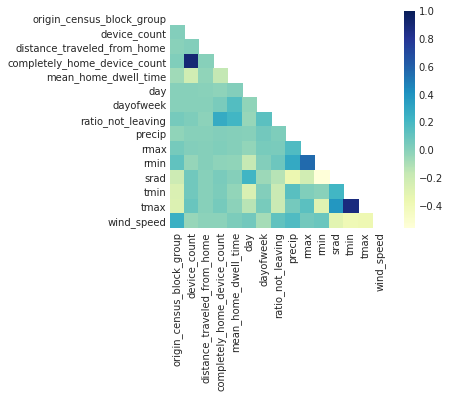

In [0]:
corr = merge_Jan_list.iloc[:,4:].corr()
corr.drop(['month','year'],1,inplace=True)
corr.drop(['month','year'],0,inplace=True)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask,0)] = True
print('Correlation Matrix : ')
sns.heatmap(corr, mask = mask,square = True, annot = False , cmap="YlGnBu")

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10,10)

- Initial Modeling for Jan data only - Part 3 - Identify an optimal response
   - Response Visualization - 1
     - distance_traveled_from_home -  highly skewed

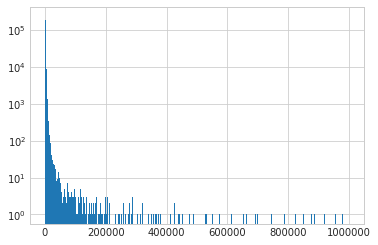

In [0]:
# # understand predictor  = distance traveled, highly right skewed
plt.hist(merge_Jan_list.distance_traveled_from_home, bins = range(0, 1000000,500), log = True)
plt.show()

In [0]:
Q1 = np.percentile(merge_Jan_list.distance_traveled_from_home, 25, interpolation = 'midpoint') 
Q3 = np.percentile(merge_Jan_list.distance_traveled_from_home, 75, interpolation = 'midpoint')
IQR = Q3 - Q1
upper = Q3 + 1.5*IQR
lower = Q1 - 1.5*IQR 
print(lower, upper, IQR)

-1304.0 5016.0 1580.0

In [0]:
# merge_Jan_list.distance_traveled_from_home[merge_Jan_list.distance_traveled_from_home > 500000].count() # 167
# merge_Jan_list.distance_traveled_from_home[merge_Jan_list.distance_traveled_from_home > 100000].count() #791
# # how many 0 distance, this is important for later transformation, 18743 , not significant
# merge_Jan_list.distance_traveled_from_home[merge_Jan_list.distance_traveled_from_home == 0].count()  # 3699
merge_Jan_list.distance_traveled_from_home[merge_Jan_list.distance_traveled_from_home > 10000].count() / merge_Jan_list.distance_traveled_from_home.count() #  0.005410860099296655
merge_Jan_list.distance_traveled_from_home[merge_Jan_list.distance_traveled_from_home > 5100].count() / merge_Jan_list.distance_traveled_from_home.count()

Out[77]: 0.0347249337441922

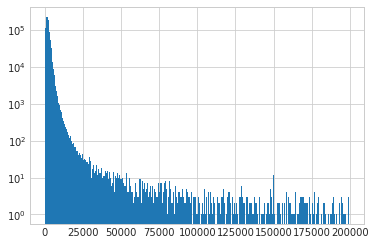

In [0]:
# Try a cut off of 50000 meters
plt.hist(merge_Jan_list.distance_traveled_from_home, bins = range(0, 200000,500), log = True)
plt.show()

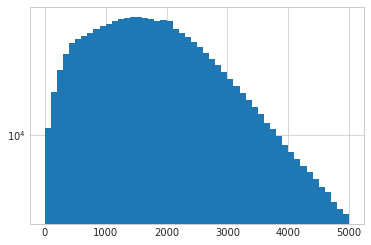

In [0]:
# Try a cut off of 10000 meters

plt.hist(merge_Jan_list.distance_traveled_from_home, bins = range(0,5100,100), log = True)
plt.show()

- Initial Modeling for Jan data only - Part 3
   - Response Visualization 2
     - mean_home_dwell_home

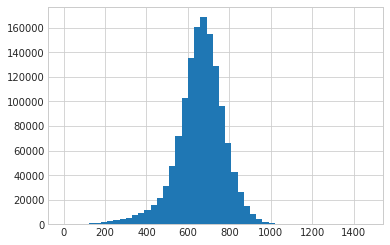

In [0]:
plt.hist(merge_Jan_list.mean_home_dwell_time, bins = range(0, 1500,30))
plt.show()# 

- Initial Modeling for Jan data only - Part 3
   - Response Visualization 3
     - ratio of not leaving

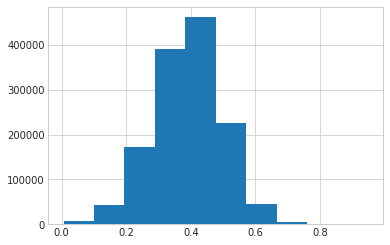

In [0]:
plt.hist(merge_Jan_list.ratio_not_leaving)
plt.show()# 

- Initial Modeling for Jan data only - Part 4
   - Visualization of response(mean_distance_traveled_from_home) with features
     - this response variable is not optimal

In [0]:
merge_Jan_1 = merge_Jan_list[merge_Jan_list.distance_traveled_from_home <= 5100]

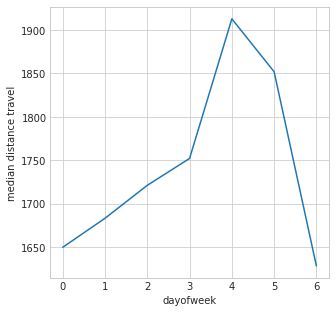

In [0]:
# take a sample for visualization
merge_Jan_1_sample = merge_Jan_1.sample(frac=0.1)

fig, ax = plt.subplots(figsize=(5,5))
merge_Jan_1_sample.groupby(['dayofweek']).median()['distance_traveled_from_home'].plot(ax=ax)
plt.ylabel('median distance travel')


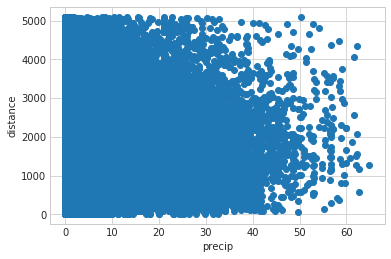

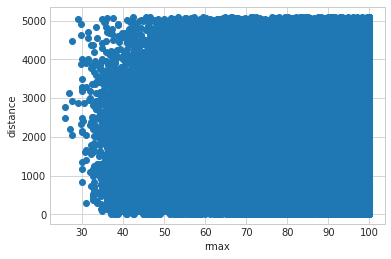

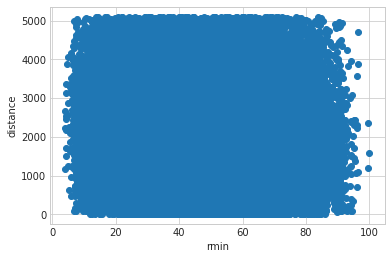

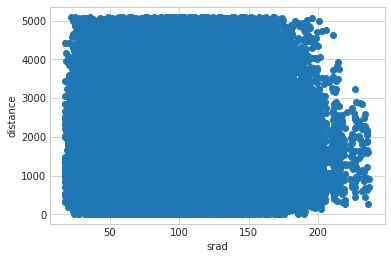

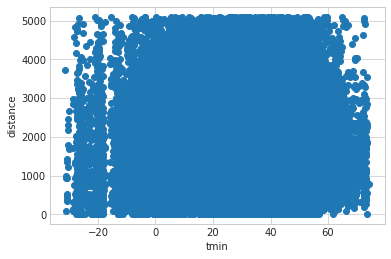

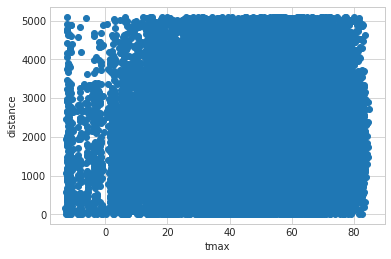

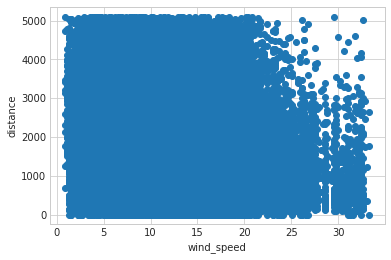

In [0]:
# relationship between distance and exploratory variables

for x in merge_Jan_1_sample.columns[14:21]:
  plt.scatter(x=x, y='distance_traveled_from_home', data=merge_Jan_1_sample)
  plt.xlabel(x)
  plt.ylabel('distance')
  plt.show()


- Initial Modeling for Jan data only - Part 5
   - Visualization of response(mean_home_dwell_time) with features

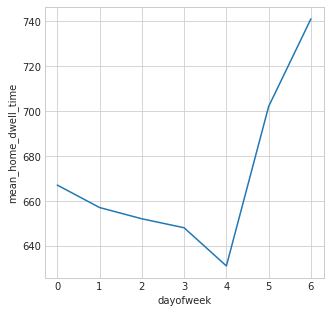

In [0]:
fig, ax = plt.subplots(figsize=(5,5))
merge_Jan_1_sample.groupby(['dayofweek']).median()['mean_home_dwell_time'].plot(ax=ax)
plt.ylabel('mean_home_dwell_time')

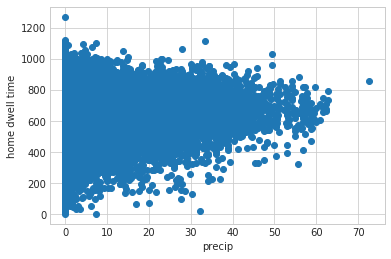

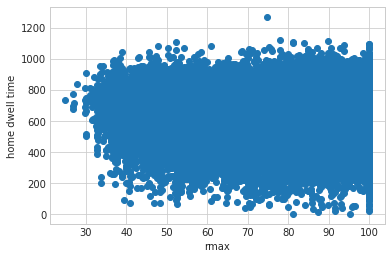

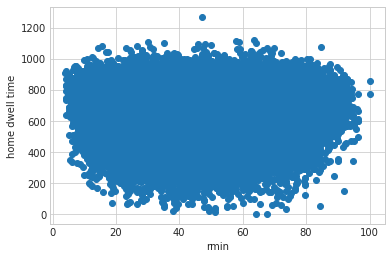

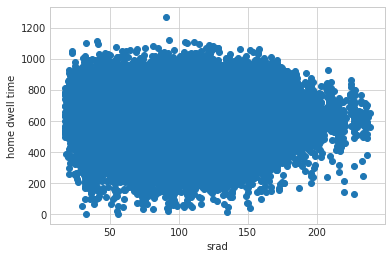

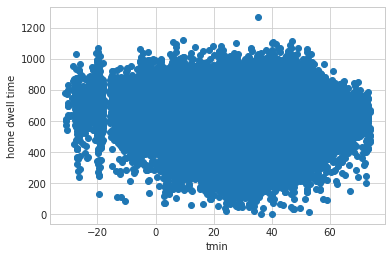

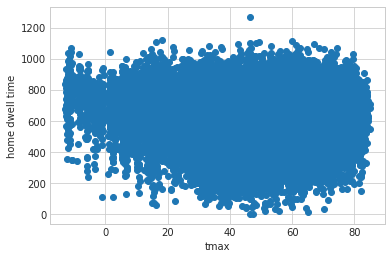

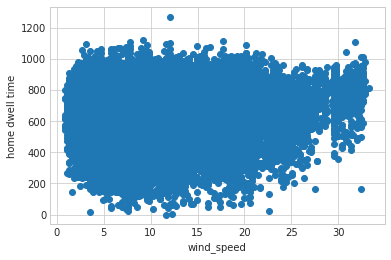

In [0]:
# relationship between distance and exploratory variables

for x in merge_Jan_1_sample.columns[14:21]:
  plt.scatter(x=x, y='mean_home_dwell_time', data=merge_Jan_1_sample)
  plt.xlabel(x)
  plt.ylabel('home dwell time')
  plt.show()

- Initial Modeling for Jan data only - Part 5
   - Visualization of response(ratio of not leaving) with features

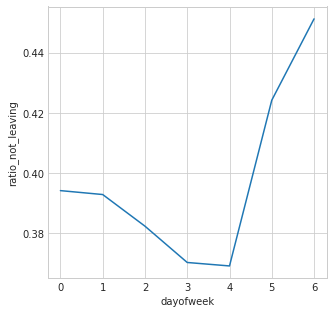

In [0]:
# take a sample for visualization
fig, ax = plt.subplots(figsize=(5,5))
merge_Jan_1_sample.groupby(['dayofweek']).median()['ratio_not_leaving'].plot(ax=ax)
plt.ylabel('ratio_not_leaving')

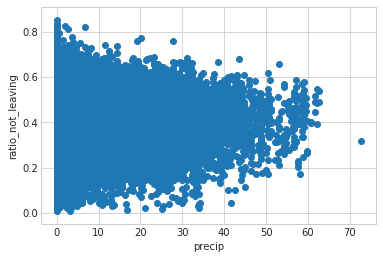

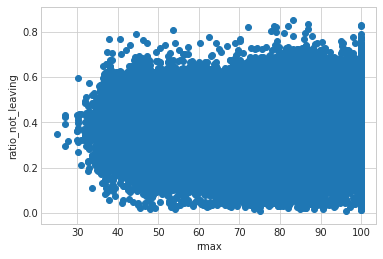

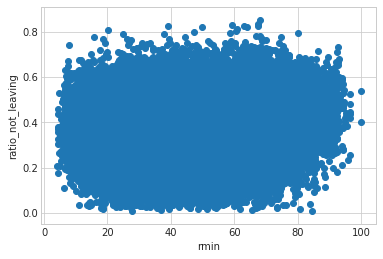

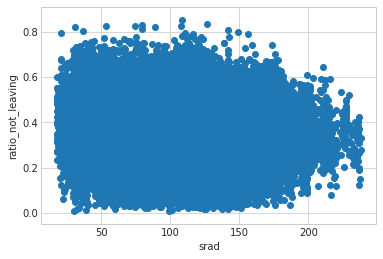

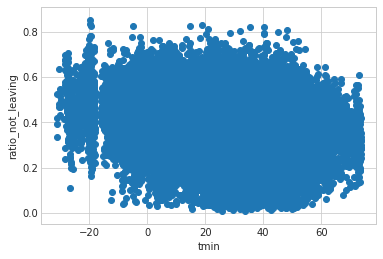

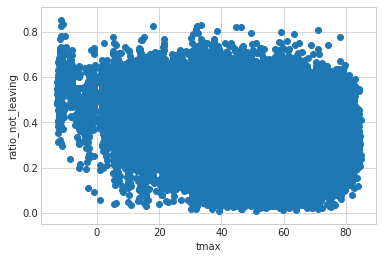

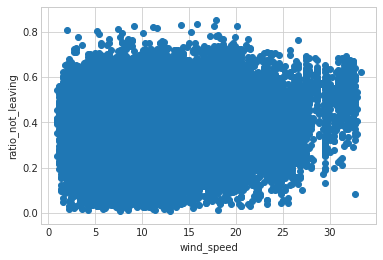

In [0]:
# relationship between distance and exploratory variables

for x in merge_Jan_1_sample.columns[14:21]:
  plt.scatter(x=x, y='ratio_not_leaving', data=merge_Jan_1_sample)
  plt.xlabel(x)
  plt.ylabel('ratio_not_leaving')
  plt.show()

In [0]:
merge_Jan_2 =  merge_Jan_1[merge_Jan_1['NAME'] == 'Chicago']
merge_Jan_2.head()

Out[21]:

,GEOID10,NAME,CLASS,ST,origin_census_block_group,device_count,distance_traveled_from_home,completely_home_device_count,mean_home_dwell_time,month,day,dayofweek,ratio_not_leaving,date,precip,rmax,rmin,srad,tmin,tmax,wind_speed,year
370188,170310101001,Chicago,city,IL,170310101001,34,96,16,555,1,1,1,0.471,2019-01-01,0.000,81.100,77.100,50.400,26.690,31.730,9.171,2019
370189,170310101001,Chicago,city,IL,170310101001,39,319,15,502,1,2,2,0.385,2019-01-02,0.000,78.700,70.400,25.700,24.350,30.830,12.079,2019
370190,170310101001,Chicago,city,IL,170310101001,43,98,10,494,1,3,3,0.233,2019-01-03,0.000,77.100,48.100,77.100,24.710,39.830,13.422,2019
370191,170310101001,Chicago,city,IL,170310101001,42,1714,12,446,1,4,4,0.286,2019-01-04,0.000,75.100,36.100,77.000,28.670,50.450,8.724,2019
370192,170310101001,Chicago,city,IL,170310101001,46,889,19,518,1,5,5,0.413,2019-01-05,0.000,76.600,36.700,77.800,31.550,53.690,8.948,2019


In [0]:
merge_Jan_2.shape

Out[11]: (63982, 22)

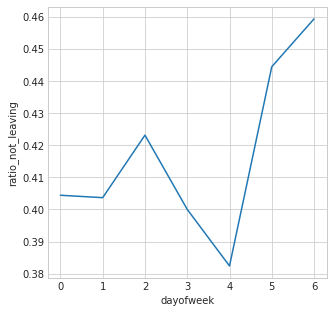

In [0]:
# take a sample for visualization
merge_Jan_2_sample = merge_Jan_2.sample(frac=0.1)
fig, ax = plt.subplots(figsize=(5,5))
merge_Jan_2_sample.groupby(['dayofweek']).median()['ratio_not_leaving'].plot(ax=ax)
plt.ylabel('ratio_not_leaving')

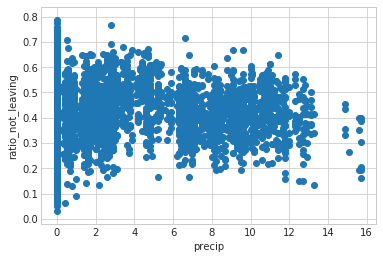

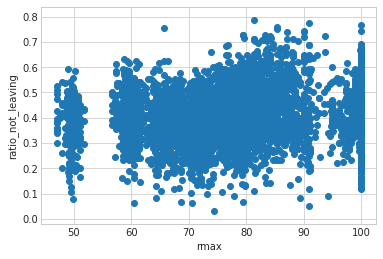

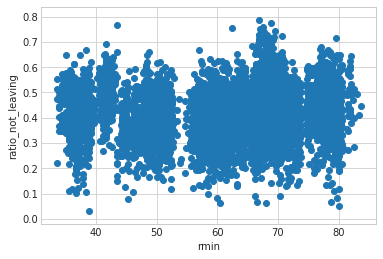

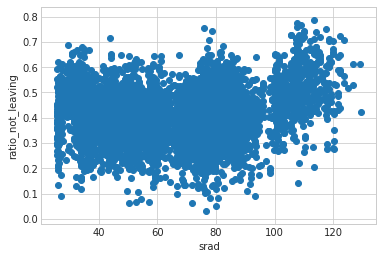

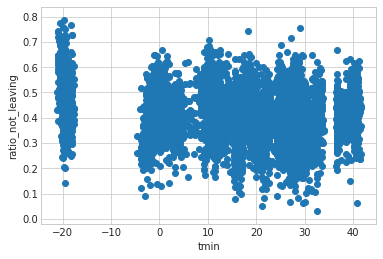

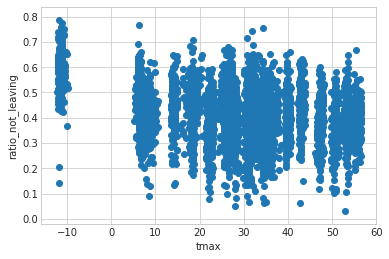

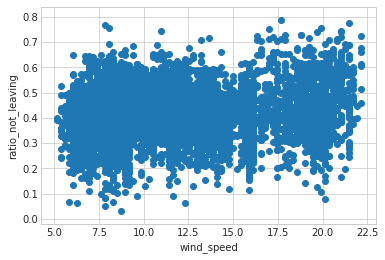

In [0]:
for x in merge_Jan_2_sample.columns[14:21]:
  plt.scatter(x=x, y='ratio_not_leaving', data=merge_Jan_2_sample)
  plt.xlabel(x)
  plt.ylabel('ratio_not_leaving')
  plt.show()

- Initial Modeling for Jan data only - Part 6
   - Feature Scaling and Encoding

Out[22]:

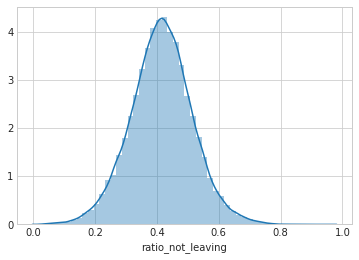

<matplotlib.axes._subplots.AxesSubplot at 0x7f78b5ffcc90>

In [0]:
y = merge_Jan_2['ratio_not_leaving']
sns.distplot(y)

In [0]:
# # lasso will drop the correlated variables, so we don't need to worry about it
# i dropped the rmin and tmin b/c multicollinearity 
X = merge_Jan_2.iloc[:,np.r_[14:16,17,19:21,11]]
X

Out[75]:

,precip,rmax,srad,tmax,wind_speed,dayofweek
370188,0.000,81.100,50.400,31.730,9.171,1
370189,0.000,78.700,25.700,30.830,12.079,2
370190,0.000,77.100,77.100,39.830,13.422,3
370191,0.000,75.100,77.000,50.450,8.724,4
370192,0.000,76.600,77.800,53.690,8.948,5
...,...,...,...,...,...,...
436396,10.000,100.000,118.200,21.110,10.066,6
436397,2.000,100.000,46.500,33.710,15.882,0
436398,0.000,100.000,94.100,5.450,19.014,1
436399,0.000,95.400,121.600,-13.450,19.238,2


In [0]:
sd_scalar = StandardScaler()
sd_scale =sd_scalar.fit(X.iloc[:,:-1])
X.iloc[:,:-1] = sd_scale.transform(X.iloc[:,:-1])
dayofweek_dic ={0:'Mon',
                1:'Tue',
                2:'Wed',
                3:'Thr',
                4:'Fri',
                5:'Sat',
                6:'Sun'           
               }
X['dayofweek'] = X['dayofweek'].apply(lambda x: dayofweek_dic[x])

In [0]:
X = pd.get_dummies(X)
X

Out[77]:

,precip,rmax,srad,tmax,wind_speed,dayofweek_Fri,dayofweek_Mon,dayofweek_Sat,dayofweek_Sun,dayofweek_Thr,dayofweek_Tue,dayofweek_Wed
370188,-0.568,-0.123,-0.778,0.179,-0.641,0,0,0,0,0,1,0
370189,-0.568,-0.284,-1.880,0.115,0.046,0,0,0,0,0,0,1
370190,-0.568,-0.392,0.414,0.750,0.363,0,0,0,0,1,0,0
370191,-0.568,-0.527,0.409,1.498,-0.747,1,0,0,0,0,0,0
370192,-0.568,-0.426,0.445,1.727,-0.694,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
436396,2.351,1.151,2.248,-0.570,-0.430,0,0,0,1,0,0,0
436397,0.016,1.151,-0.952,0.318,0.944,0,1,0,0,0,0,0
436398,-0.568,1.151,1.172,-1.674,1.684,0,0,0,0,0,1,0
436399,-0.568,0.841,2.400,-3.007,1.737,0,0,0,0,0,0,1


In [0]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components =3)
# pca.fit(X)
# X_pca = pca.transform(X)
# X_pca
# pca.explained_variance_

Out[46]: array([1.63406446, 1.48822995, 0.91400446])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

In [0]:
rlf = linear_model.Ridge()

grid = GridSearchCV(estimator=rlf, param_grid=dict(alpha=np.array([10, 1,0.1,0.01,0.001,0.0001,0])))
grid.fit(X_train, y_train)
print(grid)
# summarize the results of the grid search
print(grid.best_estimator_.alpha)

rlf_final = linear_model.Ridge(alpha = 1)
rlf_final.fit(X_train,y_train)
rlf_final_pred = rlf_final.predict(X_train)
rlf_final_pred_test = rlf_final.predict(X_test)

rlf_final_r2_score = r2_score(y_train,rlf_final_pred)
rlf_final_r2_score_test = r2_score(y_test,rlf_final_pred_test)
#pca 9.6%
print(rlf_final_r2_score,rlf_final_r2_score_test)  

GridSearchCV(cv=None, error_score=nan,
 estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
 max_iter=None, normalize=False, random_state=None,
 solver='auto', tol=0.001),
 iid='deprecated', n_jobs=None,
 param_grid={'alpha': array([1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 0.e+00])},
 pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
 scoring=None, verbose=0)
10.0
0.13982850595840823 0.13543623906875257

In [0]:
from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree=4)
X_poly = poly_reg.fit_transform(X_train)
X_poly_test = poly_reg.fit_transform(X_test)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y_train)
pol_pred = pol_reg.predict(X_poly)
pol_pred_test = pol_reg.predict(X_poly_test)

pol_r2_score = r2_score(y_train,pol_pred)
pol_r2_score_test = r2_score(y_test,pol_pred_test)
# 18%
print(pol_r2_score,pol_r2_score_test)

0.3145492774855494 0.29631197041268975

In [0]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state = 42)
rfModel = rf.fit(X_train, y_train)
rf_pred = rfModel.predict(X_train)
rf_r2_score = r2_score(y_train,rf_pred)
rf_pred_test = rfModel.predict(X_test)
rf_r2_score_test = r2_score(y_test,rf_pred_test)
print(rf_r2_score,rf_r2_score_test)

0.3878847810456796 0.34460560559878406

In [0]:
# # # Improve random forest
# rf_parameter_grid = {'n_estimators': [100,105,120]
#                      ,'max_depth': list(np.linspace(10, 30, 5, endpoint=True))     
#                      }

# rf1 = RandomForestRegressor(random_state = 42)
# grid_rf1 = GridSearchCV(rf1, rf_parameter_grid, cv=10)
# grid_rf1.fit(X_train, y_train)
# print(grid.best_score_)
# print(grid_rf1.best_estimator_)
# rf_pred_ = grid_rf1.best_estimator_.predict(X_train)
# rf_r2_score_ = r2_score(y_train,rf_pred_)
# print(rf_r2_score_)


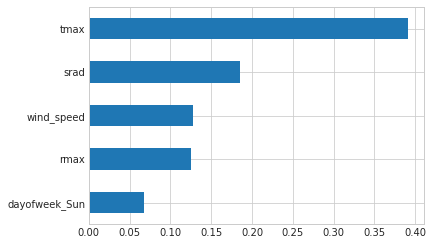

In [0]:
#  PCA(reduce features, normalize distance, mean group by geoid, max = max(by state), ratio normalize to run, preferable 40-505)
importances = pd.Series(rfModel.feature_importances_, index = X.columns)
importances.nlargest(5).plot(kind='barh').invert_yaxis()

Out[83]:

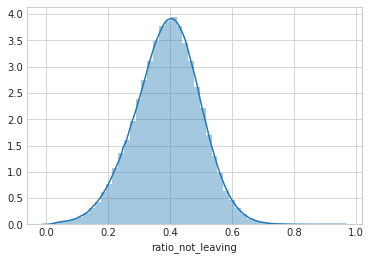

<matplotlib.axes._subplots.AxesSubplot at 0x7f78b656fe90>

In [0]:
y1 = merge_Jan_1['ratio_not_leaving']
sns.distplot(y1)

In [0]:
# # lasso will drop the correlated variables, so we don't need to worry about it
# i dropped the rmin and tmin b/c multicollinearity 
X1 = merge_Jan_1.iloc[:,np.r_[14:16,17,19:21,11]]
X1

Out[84]:

,precip,rmax,srad,tmax,wind_speed,dayofweek
13,1.000,73.900,101.200,63.950,5.592,0
14,9.300,99.300,67.400,58.550,8.500,1
15,0.000,96.100,115.000,63.590,2.684,2
22,0.000,42.600,158.000,59.450,3.803,2
27,0.000,40.900,162.200,72.230,2.684,0
...,...,...,...,...,...,...
1349688,0.000,80.900,131.000,48.290,9.619,6
1349689,0.000,60.800,140.900,38.390,7.158,0
1349690,4.500,100.000,47.600,40.010,11.632,1
1349691,0.000,75.400,126.100,36.950,16.330,2


In [0]:
sd_scalar = StandardScaler()
sd_scale =sd_scalar.fit(X1.iloc[:,:-1])
X1.iloc[:,:-1] = sd_scale.transform(X1.iloc[:,:-1])
dayofweek_dic ={0:'Mon',
                1:'Tue',
                2:'Wed',
                3:'Thr',
                4:'Fri',
                5:'Sat',
                6:'Sun'           
               }
X1['dayofweek'] = X1['dayofweek'].apply(lambda x: dayofweek_dic[x])

In [0]:
X1 = pd.get_dummies(X1)
X1

Out[86]:

,precip,rmax,srad,tmax,wind_speed,dayofweek_Fri,dayofweek_Mon,dayofweek_Sat,dayofweek_Sun,dayofweek_Thr,dayofweek_Tue,dayofweek_Wed
13,-0.244,-0.383,-0.018,0.917,-0.859,0,1,0,0,0,0,0
14,0.992,1.110,-0.880,0.590,-0.295,0,0,0,0,0,1,0
15,-0.393,0.922,0.334,0.895,-1.424,0,0,0,0,0,0,1
22,-0.393,-2.223,1.429,0.644,-1.207,0,0,0,0,0,0,1
27,-0.393,-2.323,1.536,1.419,-1.424,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1349688,-0.393,0.028,0.741,-0.032,-0.078,0,0,0,1,0,0,0
1349689,-0.393,-1.153,0.994,-0.633,-0.556,0,1,0,0,0,0,0
1349690,0.277,1.151,-1.384,-0.535,0.313,0,0,0,0,0,1,0
1349691,-0.393,-0.295,0.616,-0.720,1.224,0,0,0,0,0,0,1


In [0]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y1, test_size = 0.2)

In [0]:
from sklearn.ensemble import RandomForestRegressor

rf1 = RandomForestRegressor(random_state = 42)
rfModel = rf1.fit(X1_train, y1_train)
rf1_pred = rfModel.predict(X1_train)
rf1_r2_score = r2_score(y1_train,rf1_pred)
rf1_pred_test = rfModel.predict(X1_test)
rf1_r2_score_test = r2_score(y1_test,rf1_pred_test)
print(rf1_r2_score,rf1_r2_score_test)

0.4239697680856348 0.3362159196493033

In [0]:
# # # Improve random forest
rf_parameter_grid = {'n_estimators': [100,105,120]
                     ,'max_depth': list(np.linspace(10, 30, 5, endpoint=True))     
                     }

rf2 = RandomForestRegressor(random_state = 42)
grid_rf2 = GridSearchCV(rf2, rf_parameter_grid, cv=10)
grid_rf2.fit(X_train, y_train)
print(grid.best_score_)
print(grid_rf2.best_estimator_)
rf_pred_ = grid_rf2.best_estimator_.predict(X_train)
rf_r2_score_ = r2_score(y_train,rf_pred_)
print(rf_r2_score_)

0.13935896394681255
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
 max_depth=15.0, max_features='auto', max_leaf_nodes=None,
 max_samples=None, min_impurity_decrease=0.0,
 min_impurity_split=None, min_samples_leaf=1,
 min_samples_split=2, min_weight_fraction_leaf=0.0,
 n_estimators=120, n_jobs=None, oob_score=False,
 random_state=42, verbose=0, warm_start=False)
0.3814781943490182